# Objectives

Questions to answer with the observations data: 

*Descriptive Questions: \
--How much is the total number of observations in the last 7 days across all parks ? \
--How are the observations in the last 7 days distrubuted across the parks ? \
--What's the most/least observed species across all parks ? \
--Which species were the most/least observed in each park ? \
--Which is the most observed species in the last 7 days for each park ? 

*Inferentiel Questions: \
--Is the number of observations in the last 7 days associated with the park name ? 

Questions to answer with the species_info data: 

*Descriptive Questions: \
--Most frequent Species category \
--Conservation_status Species \
--Species category for each conservation_status 

*Inferentiel Questions: \
--is species conservation_status associated with it's category ? 

# Importing Libs + loading dfs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

In [2]:
observations = pd.read_csv('observations.csv')
species_info = pd.read_csv('species_info.csv')
observations = observations.drop_duplicates()
species_info = species_info.drop_duplicates()

observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


DataFrame observations: Each row represents the number of observations for a species in a certain park

In [3]:
species_info.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


DataFrame species: Each row represents information about a species

# Analysis

## Observations DataFrame

### Descriptive questions:

 -How much is the total number of observations in the last 7 days across all parks ?

In [28]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23281 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23281 non-null  object
 1   park_name        23281 non-null  object
 2   observations     23281 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 727.5+ KB


In [4]:
observations.observations.sum()

3312429

 -How are the sum of observations in the last 7 days distrubuted across the parks ?

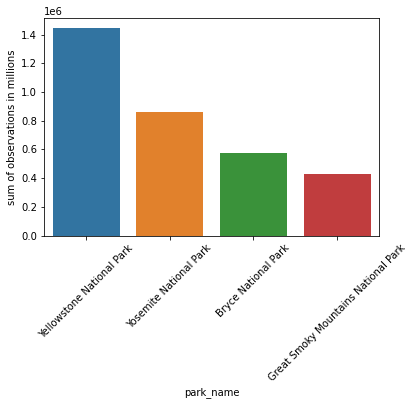

In [5]:
park_sum_observations = observations.groupby(['park_name']).observations.sum().reset_index().sort_values(by='observations', ascending=False)

sns.barplot(x=park_sum_observations.park_name, y=park_sum_observations.observations, order=park_sum_observations['park_name'])
plt.ylabel('sum of observations in millions')
plt.xticks(rotation = 45)
plt.show()

-Distribution of the observations column across all parks

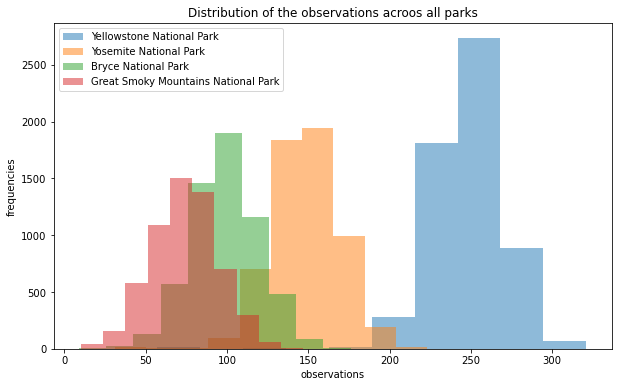

In [6]:
plt.figure(figsize=(10,6))
plt.hist(observations.observations[observations.park_name=='Yellowstone National Park'], alpha=0.5, label='Yellowstone National Park')
plt.hist(observations.observations[observations.park_name=='Yosemite National Park'], alpha=0.5, label='Yosemite National Park')
plt.hist(observations.observations[observations.park_name=='Bryce National Park'], alpha=0.5, label='Bryce National Park')
plt.hist(observations.observations[observations.park_name=='Great Smoky Mountains National Park'], alpha=0.5, label='Great Smoky Mountains National Park')
plt.title('Distribution of the observations acroos all parks')
plt.xlabel('observations')
plt.ylabel('frequencies')
plt.legend()
plt.show()

 -What's the most/least observed species across all parks ?

In [7]:
df = observations.groupby(['scientific_name']).observations.sum().reset_index().sort_values(by='observations', ascending=False)
print('most observed species:', df.iloc[0][0])

df = observations.groupby(['scientific_name']).observations.sum().reset_index().sort_values(by='observations', ascending=True)
print('Least observed species:', df.iloc[0][0])

most observed species: Holcus lanatus
Least observed species: Grus americana


 -Which species were the most/least observed in each park ?

In [8]:
# Most observed
parks_max_observations = observations.groupby(['park_name']).observations.max().reset_index()
parks_max_observations_species = parks_max_observations.merge(observations, on=['park_name', 'observations'])

for i in parks_max_observations_species.values:
    print("'{}' was the most observed species for the '{}' with {} observations." .format(i[2], i[0], i[1]))

'Valerianella radiata' was the most observed species for the 'Bryce National Park' with 176 observations.
'Sonchus asper ssp. asper' was the most observed species for the 'Great Smoky Mountains National Park' with 147 observations.
'Lycopodium tristachyum' was the most observed species for the 'Yellowstone National Park' with 321 observations.
'Ivesia shockleyi var. shockleyi' was the most observed species for the 'Yosemite National Park' with 223 observations.


In [9]:
# Least observed
parks_min_observations = observations.groupby(['park_name']).observations.min().reset_index()
parks_min_observations_species = parks_min_observations.merge(observations, on=['park_name', 'observations'])

for i in parks_min_observations_species.values:
    print("'{}' was the least observed species for the '{}' with {} observations." .format(i[2], i[0], i[1]))

'Corydalis aurea' was the least observed species for the 'Bryce National Park' with 9 observations.
'Collomia tinctoria' was the least observed species for the 'Great Smoky Mountains National Park' with 10 observations.
'Grus americana' was the least observed species for the 'Yellowstone National Park' with 57 observations.
'Noturus baileyi' was the least observed species for the 'Yosemite National Park' with 31 observations.


### Inferentiel questions

In [10]:
observations.park_name.unique()

array(['Great Smoky Mountains National Park', 'Yosemite National Park',
       'Bryce National Park', 'Yellowstone National Park'], dtype=object)

 -Is the number of observations in the last 7 days associated with the park name ?

In [11]:
### Meeting the assumptions of T-Tests, ANOVA, and Tukey:
# 1. The observations should be independently randomly sampled from the population DONE!
# 2. The standard deviations of the groups should be equal
print(observations.observations[observations.park_name=='Yellowstone National Park'].std())
print(observations.observations[observations.park_name=='Yosemite National Park'].std())
print(observations.observations[observations.park_name=='Bryce National Park'].std())
print(observations.observations[observations.park_name=='Great Smoky Mountains National Park'].std())
# 3. The data should be normally distributed…ish    DONE!
# 4. The groups created by the categorical variable must be independent

23.175947412133002
21.22054469873767
20.761238686735766
20.323467181702732


In [12]:
scipy.stats.f_oneway(
    observations.observations[observations.park_name=='Great Smoky Mountains National Park'], 
    observations.observations[observations.park_name=='Yosemite National Park'],
    observations.observations[observations.park_name=='Bryce National Park'],
    observations.observations[observations.park_name=='Yellowstone National Park']
    )

F_onewayResult(statistic=75014.12663046071, pvalue=0.0)

Since the pvalue is less than .05, we have sufficient evidence to say that the mean values across each group are not equal. \
Thus, we can proceed to perform Tukey’s Test to determine exactly which group means are different.

In [13]:
tukey = pairwise_tukeyhsd(endog=observations['observations'],
                          groups=observations['park_name'],
                          alpha=0.05)
print(tukey)

                              Multiple Comparison of Means - Tukey HSD, FWER=0.05                               
               group1                              group2               meandiff p-adj   lower    upper   reject
----------------------------------------------------------------------------------------------------------------
                Bryce National Park Great Smoky Mountains National Park -24.7557 0.001  -25.7747 -23.7366   True
                Bryce National Park           Yellowstone National Park 148.9618 0.001  147.9427 149.9808   True
                Bryce National Park              Yosemite National Park  49.3271 0.001   48.3081   50.346   True
Great Smoky Mountains National Park           Yellowstone National Park 173.7175 0.001  172.6982 174.7367   True
Great Smoky Mountains National Park              Yosemite National Park  74.0827 0.001   73.0636  75.1019   True
          Yellowstone National Park              Yosemite National Park -99.6347 0.001 -100.6538

Since we have a pvalue that is less than .05 across each park and the other, we have sufficient evidence to say in our case the park name and the number of observations in the last 7 days are associated

## Species_info DataFrame

### Descriptive questions:

 -Most frequent Species category

c:\Users\Oussama ZIDI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


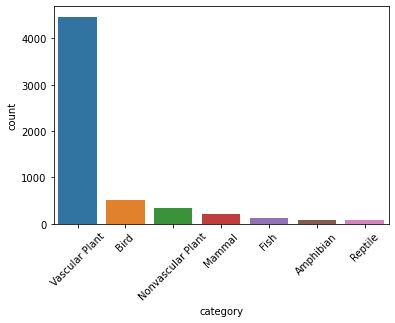

In [14]:
sns.countplot(species_info.category, order=species_info.category.value_counts().index)
plt.xticks(rotation = 45)
plt.show()

 -Species conservation_status

c:\Users\Oussama ZIDI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


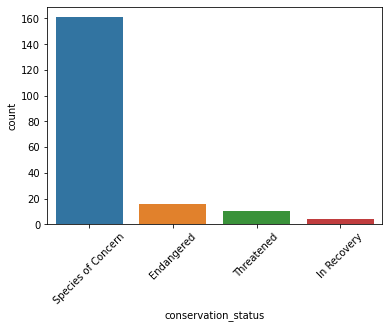

In [15]:
species_info_Intervention = species_info.conservation_status.reset_index()

sns.countplot(species_info_Intervention.conservation_status, order=species_info_Intervention.conservation_status.value_counts().index)
plt.xticks(rotation = 45)
plt.show()

 -Species conservation_status (Without No_intervention)

In [16]:
species_info.conservation_status = species_info.conservation_status.fillna('No_Intervention')

c:\Users\Oussama ZIDI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


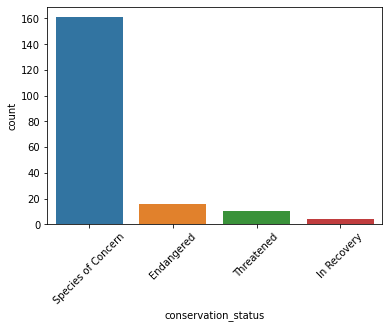

In [17]:
species_info_Intervention = species_info[species_info.conservation_status != 'No_Intervention']

sns.countplot(species_info_Intervention.conservation_status, order=species_info_Intervention.conservation_status.value_counts().index)
plt.xticks(rotation = 45)
plt.show()

Species category for each conservation_status

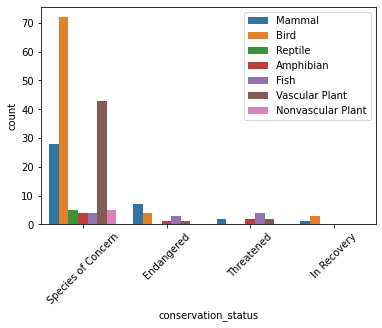

In [18]:
sns.countplot(data=species_info_Intervention, x='conservation_status', hue='category')
plt.legend(loc=1)
plt.xticks(rotation = 45)
plt.show()

### Inferentiel questions:

--is species conservation_status associated with it's category ? 

In [19]:
## Assumptions of a Chi-Square Test
# 1. The observations should be independently randomly sampled from the population      DONE!
# 2. The categories of both variables must be mutually exclusive        DONE!
# 3. The groups should be independent       DONE!

In [20]:
cross_tab = pd.crosstab(species_info_Intervention['category'],
                            species_info_Intervention['conservation_status'], 
                               margins = False).sort_values(by=['Species of Concern', 'Endangered'], ascending=[False, False])
cross_tab = cross_tab[['Species of Concern', 'Endangered', 'Threatened', 'In Recovery']]
cross_tab

conservation_status,Species of Concern,Endangered,Threatened,In Recovery
category,,,,
Bird,72,4,0,3
Vascular Plant,43,1,2,0
Mammal,28,7,2,1
Nonvascular Plant,5,0,0,0
Reptile,5,0,0,0
Fish,4,3,4,0
Amphibian,4,1,2,0


In [21]:
stat, p, dof, expected = chi2_contingency(cross_tab)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 1.8909788349761653e-05
Dependent (reject H0)


The variables (Species category) and (conservation_status) do have a significant relation

In [22]:
species_info_Intervention

,category,scientific_name,common_names,conservation_status
7,Mammal,Canis latrans,Coyote,Species of Concern
8,Mammal,Canis lupus,Gray Wolf,Endangered
9,Mammal,Canis rufus,Red Wolf,Endangered
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern
...,...,...,...,...
5302,Vascular Plant,Callitriche marginata,Winged Water-Starwort,Species of Concern
5399,Vascular Plant,Camissonia sierrae ssp. alticola,"Mono Hot Springs Evening Primrose, Mono Hot Sp...",Species of Concern
5426,Vascular Plant,Epilobium oreganum,"Grants Pass Willowherb, Oregon Fireweed",Species of Concern
5436,Vascular Plant,Botrychium ascendens,"Trianglelobe Moonwort, Upswept Moonwort",Species of Concern


In [23]:
species_info_Intervention.conservation_status.value_counts()

Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: conservation_status, dtype: int64

In [24]:
new_df = pd.merge(left=observations, right=species_info_Intervention, how='inner', left_on='scientific_name', right_on='scientific_name')

new_df[new_df['conservation_status']=='In Recovery']

,scientific_name,park_name,observations,category,common_names,conservation_status
201,Canis lupus,Yosemite National Park,35,Mammal,"Gray Wolf, Wolf",In Recovery
204,Canis lupus,Bryce National Park,27,Mammal,"Gray Wolf, Wolf",In Recovery
207,Canis lupus,Bryce National Park,29,Mammal,"Gray Wolf, Wolf",In Recovery
210,Canis lupus,Bryce National Park,74,Mammal,"Gray Wolf, Wolf",In Recovery
213,Canis lupus,Great Smoky Mountains National Park,15,Mammal,"Gray Wolf, Wolf",In Recovery
216,Canis lupus,Yellowstone National Park,60,Mammal,"Gray Wolf, Wolf",In Recovery
219,Canis lupus,Yellowstone National Park,67,Mammal,"Gray Wolf, Wolf",In Recovery
222,Canis lupus,Yellowstone National Park,203,Mammal,"Gray Wolf, Wolf",In Recovery
225,Canis lupus,Great Smoky Mountains National Park,14,Mammal,"Gray Wolf, Wolf",In Recovery
228,Canis lupus,Yosemite National Park,117,Mammal,"Gray Wolf, Wolf",In Recovery


# Addons

## Top 5 species (number of observations) for each category

In [25]:
all_data = pd.merge(left=observations, right=species_info)
all_data = all_data.sort_values(by=['category', 'observations'], ascending=[True, False])
all_data.head()

,scientific_name,park_name,observations,category,common_names,conservation_status
20600,Ambystoma opacum,Yellowstone National Park,301,Amphibian,Marbled Salamander,No_Intervention
16144,Notophthalmus viridescens viridescens,Yellowstone National Park,291,Amphibian,Eastern Red-Spotted Newt,No_Intervention
4753,Ambystoma mavortium melanostictum,Yellowstone National Park,287,Amphibian,Blotched Tiger Salamander,No_Intervention
16921,Pseudotriton ruber schencki,Yellowstone National Park,282,Amphibian,Blackchin Red Salamander,No_Intervention
20589,Batrachoseps diabolicus,Yellowstone National Park,282,Amphibian,Hell Hollow Slender Salamander,No_Intervention


In [26]:
new_data = []
for i in species_info.category.value_counts().index:
    new_data.append(all_data[all_data.category==i].head())

new_data = pd.concat(new_data)
new_data

,scientific_name,park_name,observations,category,common_names,conservation_status
11604,Lycopodium tristachyum,Yellowstone National Park,321,Vascular Plant,"Deep-Root Clubmoss, Ground Cedar",No_Intervention
5498,Castilleja miniata,Yellowstone National Park,317,Vascular Plant,"Giant Red Indian Paintbrush, Great Red Indian ...",No_Intervention
3363,Cryptantha fendleri,Yellowstone National Park,316,Vascular Plant,"Fendler's Cryptantha, Sanddune Catseye, Sanddu...",No_Intervention
22211,Dracocephalum parviflorum,Yellowstone National Park,316,Vascular Plant,American Dragonhead,No_Intervention
20317,Bidens tripartita,Yellowstone National Park,314,Vascular Plant,"Stick-Tight, Three-Lobe Beggar-Ticks",No_Intervention
2476,Spinus lawrencei,Yellowstone National Park,305,Bird,Lawrence's Goldfinch,No_Intervention
16419,Aythya americana,Yellowstone National Park,304,Bird,Redhead,No_Intervention
6069,Perdix perdix,Yellowstone National Park,300,Bird,"Gray Partridge, Grey Partridge",No_Intervention
11477,Myiarchus crinitus,Yellowstone National Park,298,Bird,Great Crested Flycatcher,No_Intervention
21679,Setophaga coronata,Yellowstone National Park,298,Bird,Yellow-Rumped Warbler,No_Intervention


## A function that takes in a range of 2 values and returns a dataframe with observations in that given range

In [27]:
def observations_range(lowerbound, upperbound):
    return observations[(observations.observations>= int(lowerbound)) & (observations.observations<= int(upperbound))]

observations_range(0, 10)

,scientific_name,park_name,observations
9418,Corydalis aurea,Bryce National Park,9
15511,Collomia tinctoria,Great Smoky Mountains National Park,10
